In [1]:
import hypernetx as hnx
import matplotlib as mp
import networkx as nx
import qf.cc
import qf.graphs
%matplotlib inline

In [2]:
def add_directed_hyperedge(H, sources, target):
    H.add_edge(hnx.Entity(H.number_of_edges(), sources + [target], props={'target': target}))

def add_directed_hyperedges(H, stpairs):
    for st in stpairs:
        add_directed_hyperedge(H, st[0], st[1])

In [3]:
def hg2g(H):
    G = nx.MultiDiGraph()
    G.add_nodes_from([x.uid for x in H.nodes()])
    G.add_nodes_from([x.uid for x in H.edges()])
    for h in H.edges():
        target = h.props['target']
        for e in h.elements:
            if e != target:
                G.add_edge(e, h.uid)
            else:
                G.add_edge(h.uid, e)
    return G

In [4]:
def visualize_hg(H, colors = None):
    if colors is None:
        colors = {v.uid: 0 for v in H.nodes()}
    cols = qf.util.colors(max(set(colors.values()))+1)
    hnx.drawing.draw(H, 
                 with_edge_labels=False,
                 edges_kwargs={
                     'edgecolors': 'black'
                 },
                 nodes_kwargs={
                     'facecolors': [cols[colors[v.uid]] for v in H.nodes()]
                 }
                )

In [5]:
H = hnx.Hypergraph()
add_directed_hyperedges(H, [
    (['FN'], 'TH'),
    (['TH'], 'JV'),
    (['BM', 'FN'], 'JA'),
    (['JV', 'JU', 'CH'], 'BM'),
    (['JU', 'CH', 'BR', 'CN', 'CC', 'JV'], 'BM'),
    (['TH'], 'GP'),
    (['GP'], 'MP'),
    (['MA'], 'GP')
])

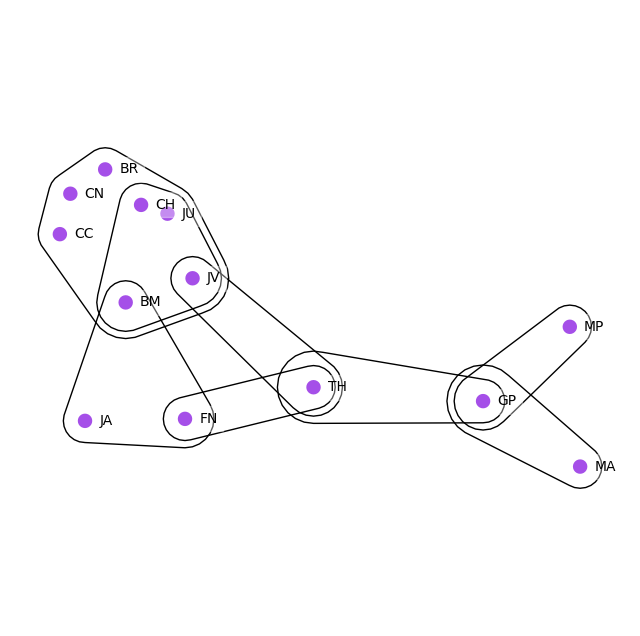

In [6]:
visualize_hg(H)

In [8]:
G = hg2g(H)
cc = qf.cc.cardon_crochemore(G)
#qf.graphs.visualize(G, cc)

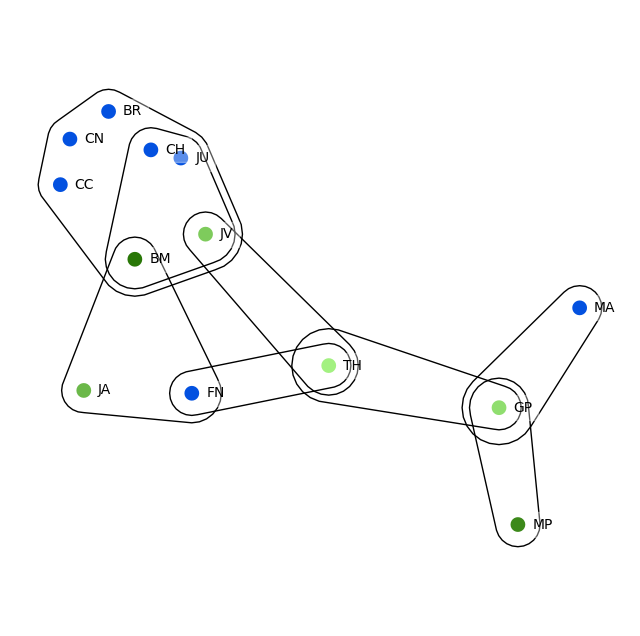

In [9]:
visualize_hg(H, cc)